# running the mario kart data 

In [2]:
# we need the library json as the reddit data is stored in line-delimited json objects
# (one json object in each line, with each line representing a Reddit comment)
import json

# function to load all comment data into a list of strings
# Input: the path of the file including our data
# Output: a list of strings including the body of the Reddit comments
def load_reddit_comment_data(data_directory):
    comments_data = []  # list object that will store the loaded Reddit comments

    # we first open the file that includes our dataset
    with open(data_directory, 'r', encoding='utf-8') as f:
        # iterate the file, reading it line by line
        for line in f:
            # load the data pertaining to a line into a json object in memory
            data = json.loads(line)

            # check if 'body' key exists and the comment is not removed
            if 'body' in data and data['body'] != "[removed]":
                comments_data.append(data['body'])

    # the method returns all the loaded Reddit comments
    return comments_data


In [3]:
import os

path_directory = r"C:\Users\ebbea\OneDrive - Delft University of Technology\DELFT\JAAR 3\Minor\NLP\Data"
json_files = ['mariokart_comments.ndjson', 'mariokart_submissions.ndjson', 'nintendo_comments.ndjson', 'nintendo_submissions.ndjson']

full_paths = [os.path.join(path_directory, filename) for filename in json_files]

In [4]:
mariokart_comments = load_reddit_comment_data(full_paths[0])
mariokart_submissions = load_reddit_comment_data(full_paths[1])
nintendo_comments = load_reddit_comment_data(full_paths[2])
nintendo_submissions = load_reddit_comment_data(full_paths[3])

In [5]:
mariokart_comments += mariokart_submissions + nintendo_comments + nintendo_submissions

In [6]:
import nltk
import re
import pandas as pd
from nltk.util import ngrams
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
stop_words = set(stopwords.words('english'))

# function to preprocess the Reddit comments
# Input: a string that includes a text corresponding to a Reddit comment
# Output: a string with the preprocessed Reddit comment
def preprocess(text):
    text = text.lower()  # convert text to lower-case
    text = re.sub('&gt;', '', text) # remove some special characters from the data &gt; corresponds to >
    text = re.sub('&amp;', '', text) # remove some special characters from the data &amp; corresponds to &
    text = re.sub(r'\s+', ' ', text)  # eliminate duplicate whitespaces using regex
    text = re.sub(r'\[[^]]*\]', '', text)  # remove text in square brackets
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-z0-9\s]', '', text)  # remove punctuation (keep only characters and numbers)
    return text

In [7]:
# run our function to preprocess all comments
preprocessed_comments_including_stopwords = [preprocess(comment) for comment in mariokart_comments]

In [8]:
# Tokenize the comments and remove the stopwords
preprocessed_comments = [] # list holding our dataset (each element corresponds to a preprocessed comment as a string)
for comment in preprocessed_comments_including_stopwords:
    # tokenize the comments and remove stopwords
    filtered_words = [w for w in word_tokenize(comment) if w not in stop_words]
    # join the words back into a sentence
    preprocessed_comments.append(' '.join(filtered_words))

In [9]:
from textblob import TextBlob

# Example function to get sentiment
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

get_sentiment('i used to love this track but now i love it')


0.5

In [10]:
def get_tracknames_regex() -> list[str]:
    with open('MarioKart_tracks_regex.txt', 'r') as file:
        tracks = [line.strip() for line in file.readlines()]
    return tracks

def get_tracknames():
    with open('MarioKart_tracks.txt', 'r') as file:
        tracks = [line.strip() for line in file.readlines()]
    return tracks

In [11]:
import re


def get_track_mentions(comments: list[str], tracks: list[str]):
    filtered_comments = []

    for comment in comments:
        if any(re.search(track, comment) for track in tracks):
            filtered_comments.append(comment)

    return filtered_comments



In [12]:
tracknames_regex = get_tracknames_regex()
track_comments = get_track_mentions(preprocessed_comments, tracknames_regex)

In [13]:
tracknames = get_tracknames()

In [14]:
compiled_patterns = [re.compile(pattern, re.IGNORECASE) for pattern in tracknames_regex]

# Initialize an empty dictionary for the final track comments
track_comments_dict = {name: [] for name in tracknames}

# Iterate over each compiled pattern and the corresponding track name from tracknames
for pattern, track_name in zip(compiled_patterns, tracknames):
    # Check each comment to see if it contains the track pattern
    for comment in track_comments:
        if pattern.search(comment):
            track_comments_dict[track_name].append(comment)

In [15]:
length_dict = {key: len(value) for key, value in track_comments_dict.items()}
length_dict

{'ï»¿SNES Mario Circuit 3': 123,
 'SNES Bowser Castle 3': 98,
 'SNES Donut Plains 3': 158,
 'Rainbow Road (all)': 3429,
 'N64 Kalimari Desert': 463,
 "N64 Toad's Turnpike": 52,
 'N64 Choco Mountain': 275,
 'N64 Royal Raceway': 522,
 'N64 Yoshi Valley': 204,
 'GBA Riverside Park': 163,
 'GBA Mario Circuit': 1339,
 'GBA Boo Lake': 507,
 'GBA Cheese Land': 482,
 'GBA Sky Garden': 503,
 'GBA Sunset Wilds': 280,
 'GBA Snow Land': 592,
 'GBA Ribbon Road': 636,
 'GCN Baby Park': 1140,
 'GCN Dry Dry Desert': 179,
 'GCN Daisy Cruiser': 435,
 'GCN Waluigi Stadium': 675,
 'GCN Sherbet Land': 224,
 'GCN Yoshi Circuit': 266,
 'GCN DK Mountain': 543,
 'DS Cheep Cheep Beach': 89,
 'DS Waluigi Pinball': 1065,
 'DS Shroom Ridge': 485,
 'DS Tick-Tock Clock': 114,
 'DS Mario Circuit': 1339,
 'DS Wario Stadium': 447,
 'DS Peach Gardens': 644,
 'Wii Moo Moo Meadows': 176,
 'Wii Mushroom Gorge': 631,
 'Wii Coconut Mall': 838,
 'Wii DK Summit': 590,
 "Wii Wario's Gold Mine": 9,
 'Wii Daisy Circuit': 194,
 'W

### Fast way of checking sentiment, but inaccurate

In [16]:
from textblob import TextBlob

# Dictionary to hold the count of positive and negative comments for each track
track_sentiment_counts = {}

for track, comments in track_comments_dict.items():
    positive_count = 0
    negative_count = 0

    for comment in comments:
        sentiment = TextBlob(comment).sentiment.polarity
        if sentiment > 0:
            positive_count += 1
        elif sentiment < 0:
            negative_count += 1

    track_sentiment_counts[track] = (positive_count, negative_count)

from textblob import TextBlob
import heapq

# Dictionary to hold the best and worst 5 comments for each track
track_best_worst_comments = {}

for track, comments in track_comments_dict.items():
    # Lists to hold the top 5 positive and negative comments
    top_positive = []
    top_negative = []

    for comment in comments:
        sentiment = TextBlob(comment).sentiment.polarity

        if sentiment > 0:
            # Add to positive comments and maintain size 5
            heapq.heappush(top_positive, (-sentiment, comment))
            if len(top_positive) > 5:
                heapq.heappop(top_positive)

        elif sentiment < 0:
            # Add to negative comments and maintain size 5
            heapq.heappush(top_negative, (sentiment, comment))
            if len(top_negative) > 5:
                heapq.heappop(top_negative)

    # Convert heap to sorted list
    best_comments = [heapq.heappop(top_positive)[1] for _ in range(len(top_positive))][::-1]
    worst_comments = [heapq.heappop(top_negative)[1] for _ in range(len(top_negative))][::-1]

    track_best_worst_comments[track] = {'Best Comments': best_comments, 'Worst Comments': worst_comments}

# Example usage
# track_comments_dict = {'Track1': ['Good track', 'Bad track', ...], 'Track2': [...], ...}
# detailed_comments = track_best_worst_comments


### Slow but efficient way of checking sentiment using BERT

In [17]:
import transformers

In [18]:
from transformers import pipeline

# Initialize the HuggingFace sentiment-analysis pipeline
nlp = pipeline("sentiment-analysis")

# Function to truncate comments to the max length accepted by BERT
def truncate_comment(comment, max_length=400):
    # Tokenize the comment and truncate the number of tokens if necessary
    tokens = comment.split()
    if len(tokens) > max_length:
        return ' '.join(tokens[:max_length])
    return comment

def analyze_sentiment(comment):
    try:
        truncated_comment = truncate_comment(comment)
        sentiment_result = nlp(truncated_comment)[0]
        return sentiment_result['label'], sentiment_result['score']
    except Exception as e:
        # Fallback to TextBlob
        sentiment = TextBlob(comment).sentiment.polarity
        return ("POSITIVE" if sentiment > 0 else "NEGATIVE", abs(sentiment))
    
# Dictionary to hold the count of positive and negative comments for each track
track_sentiment_counts_BERT = {}

for track, comments in track_comments_dict.items():
    positive_count = 0
    negative_count = 0

    for comment in comments:
        # Truncate comment to the max length
        truncated_comment = truncate_comment(comment)

        sentiment, score = analyze_sentiment(comment)

        if sentiment == 'POSITIVE':
            positive_count += 1

        elif sentiment == 'NEGATIVE':
            negative_count += 1

    track_sentiment_counts_BERT[track] = (positive_count, negative_count)

    print(f'Finished Track: {track}')

# Example usage
# track_comments_dict = {'Track1': ['Good track', 'Bad track', ...], 'Track2': [...], ...}
# detailed_comments = track_best_worst_comments


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Finished Track: ï»¿SNES Mario Circuit 3
Finished Track: SNES Bowser Castle 3
Finished Track: SNES Donut Plains 3
Finished Track: Rainbow Road (all)
Finished Track: N64 Kalimari Desert
Finished Track: N64 Toad's Turnpike
Finished Track: N64 Choco Mountain
Finished Track: N64 Royal Raceway
Finished Track: N64 Yoshi Valley
Finished Track: GBA Riverside Park
Finished Track: GBA Mario Circuit
Finished Track: GBA Boo Lake
Finished Track: GBA Cheese Land
Finished Track: GBA Sky Garden
Finished Track: GBA Sunset Wilds
Finished Track: GBA Snow Land
Finished Track: GBA Ribbon Road


Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors


Finished Track: GCN Baby Park
Finished Track: GCN Dry Dry Desert
Finished Track: GCN Daisy Cruiser
Finished Track: GCN Waluigi Stadium
Finished Track: GCN Sherbet Land
Finished Track: GCN Yoshi Circuit
Finished Track: GCN DK Mountain
Finished Track: DS Cheep Cheep Beach
Finished Track: DS Waluigi Pinball
Finished Track: DS Shroom Ridge
Finished Track: DS Tick-Tock Clock
Finished Track: DS Mario Circuit
Finished Track: DS Wario Stadium
Finished Track: DS Peach Gardens
Finished Track: Wii Moo Moo Meadows
Finished Track: Wii Mushroom Gorge
Finished Track: Wii Coconut Mall
Finished Track: Wii DK Summit
Finished Track: Wii Wario's Gold Mine
Finished Track: Wii Daisy Circuit
Finished Track: Wii Koopa Cape
Finished Track: Wii Maple Treeway
Finished Track: Wii Grumble Volcano
Finished Track: Wii Moonview Highway
Finished Track: 3DS Toad Circuit
Finished Track: 3DS Music Park
Finished Track: 3DS Rock Rock Mountain
Finished Track: 3DS Piranha Plant Slide
Finished Track: 3DS Neo Bowser City
Finis

In [19]:

track_best_worst_comments

{'ï»¿SNES Mario Circuit 3': {'Best Comments': ['definitely want elevation adjustments mc4 badly lacks personality even snes track since mostly mc3 clone know somewhat sacrilegious snes mc track really think needs done give mc4 identity',
   'boring play doesnt look great dumbed compared wii version well makes way easy theres basically zero skill involved trying fit gaps never understood simple track thing either already simple tracks like yoshis circuit excitebike snes rainbow road ramps doesnt mean track immediately simple donut plains mc3 bland',
   'mc3 looks really bad still fun drive ive really enjoyed driving wii mk8d gotten donut plains treatment visually maybe people would appreciate',
   'could im unsure mean mc4 snes mario circuit track never remade minus super circuit obviously yet chose mc3 instead already wii snow land added gba pattern tour handheld retro gba bcs lightning cup reverse star cup right way around etc still continue last remaining lightning cup track added to

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_top_10_stacked_bar(track_reviews):
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame.from_dict(track_reviews, orient='index', columns=['Positive', 'Negative'])
    
    # Calculate the total reviews (positive + negative) and sort
    df['Total'] = df['Positive'] + df['Negative']
    df_sorted = df.sort_values(by='Total', ascending=False).head(10)

    # Plotting
    fig, ax = plt.subplots()
    df_sorted[['Positive', 'Negative']].plot(kind='bar', stacked=True, ax=ax)
    ax.set_title('Top 10 Most Mentioned Mario Kart Tracks')
    ax.set_xlabel('Track')
    ax.set_ylabel('Number of Reviews')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Example usage
# track_reviews = {'Track1': (5, 3), 'Track2': (8, 2), ... }
# plot_top_10_stacked_bar(track_reviews)


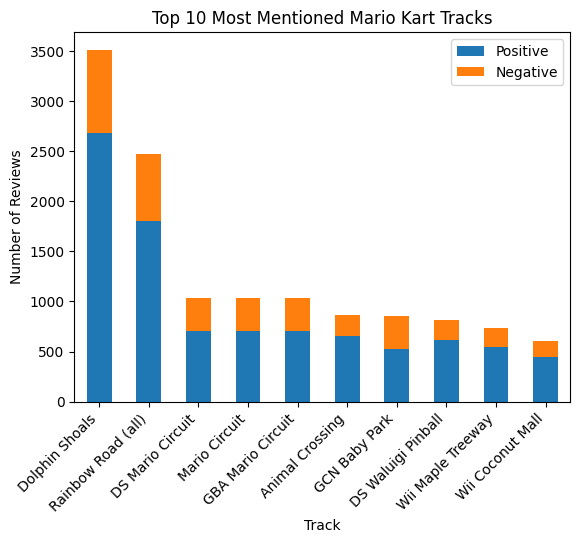

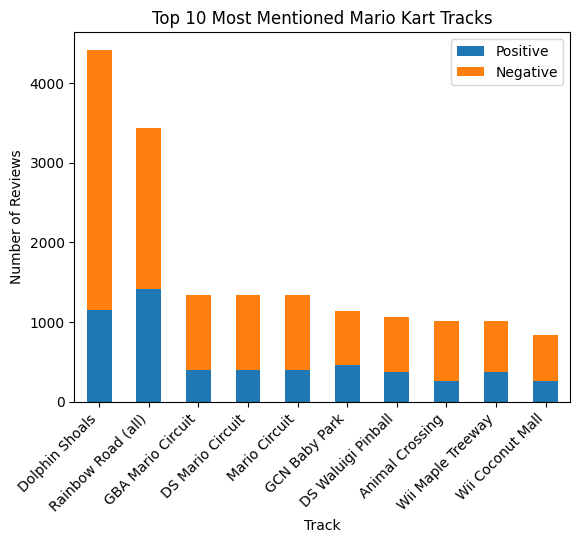

In [21]:
plot_top_10_stacked_bar(track_sentiment_counts)
plot_top_10_stacked_bar(track_sentiment_counts_BERT)

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_top_positive_percentage(track_reviews, min_reviews=10, num_bars=10):
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame.from_dict(track_reviews, orient='index', columns=['Positive', 'Negative'])
    
    # Calculate the total number of reviews and the percentage of positive reviews
    df['Total_Reviews'] = df['Positive'] + df['Negative']
    df['Positive_Percentage'] = (df['Positive'] / df['Total_Reviews']) * 100

    # Filter out tracks with fewer than the minimum required number of reviews
    df_filtered = df[df['Total_Reviews'] >= min_reviews]

    # Sort by the percentage of positive reviews and select the top 10
    df_sorted = df_filtered.sort_values(by='Positive_Percentage', ascending=False).head(num_bars)

    # Plotting
    fig, ax = plt.subplots()
    df_sorted['Positive_Percentage'].plot(kind='bar', ax=ax, color='green')
    ax.set_title(f'Top 10 Tracks with Highest Percentage of Positive Reviews (Min {min_reviews} Reviews)')
    ax.set_xlabel('Track')
    ax.set_ylabel('Percentage of Positive Reviews (%)')
    plt.xticks(rotation=45, ha='right')
    plt.show()

def plot_worst_positive_percentage(track_reviews, min_reviews=10, num_bars=10):
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame.from_dict(track_reviews, orient='index', columns=['Positive', 'Negative'])
    
    # Calculate the total number of reviews and the percentage of positive reviews
    df['Total_Reviews'] = df['Positive'] + df['Negative']
    df['Positive_Percentage'] = (df['Positive'] / df['Total_Reviews']) * 100

    # Filter out tracks with fewer than the minimum required number of reviews
    df_filtered = df[df['Total_Reviews'] >= min_reviews]

    # Sort by the percentage of positive reviews and select the top 10
    df_sorted = df_filtered.sort_values(by='Positive_Percentage', ascending=True).head(num_bars)

    # Plotting
    fig, ax = plt.subplots()
    df_sorted['Positive_Percentage'].plot(kind='bar', ax=ax, color='green')
    ax.set_title(f'Top 10 Tracks with Lowest Percentage of Positive Reviews (Min {min_reviews} Reviews)')
    ax.set_xlabel('Track')
    ax.set_ylabel('Percentage of Positive Reviews (%)')
    plt.xticks(rotation=45, ha='right')
    plt.show()
# Example usage
# track_reviews = {'Track1': (5, 3), 'Track2': (8, 2), ... }
# plot_top_10_positive_percentage(track_reviews)
def plot_top_n_negative_reviews(track_reviews, n=10):
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame.from_dict(track_reviews, orient='index', columns=['Positive', 'Negative'])

    # Sort by the number of negative reviews and select the top N
    df_sorted = df.sort_values(by='Negative', ascending=False).head(n)

    # Plotting
    fig, ax = plt.subplots()
    df_sorted['Negative'].plot(kind='bar', ax=ax, color='red')
    ax.set_title(f'Top {n} Tracks with Most Negative Reviews')
    ax.set_xlabel('Track')
    ax.set_ylabel('Number of Negative Reviews')
    plt.xticks(rotation=45, ha='right')
    plt.show()

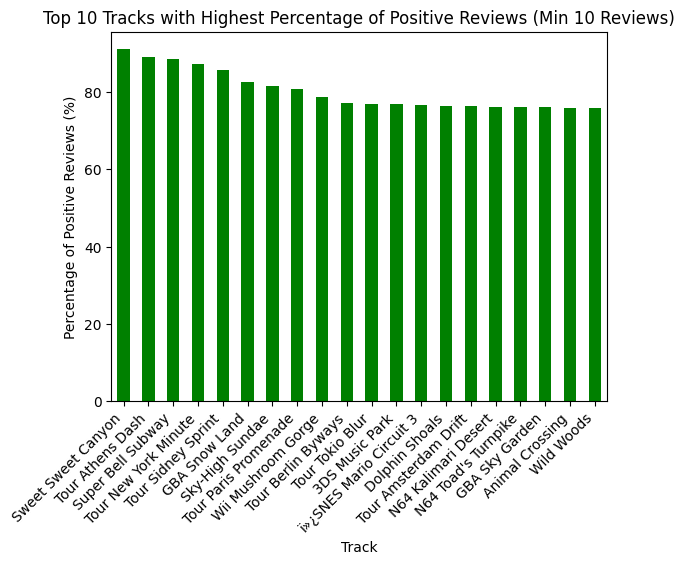

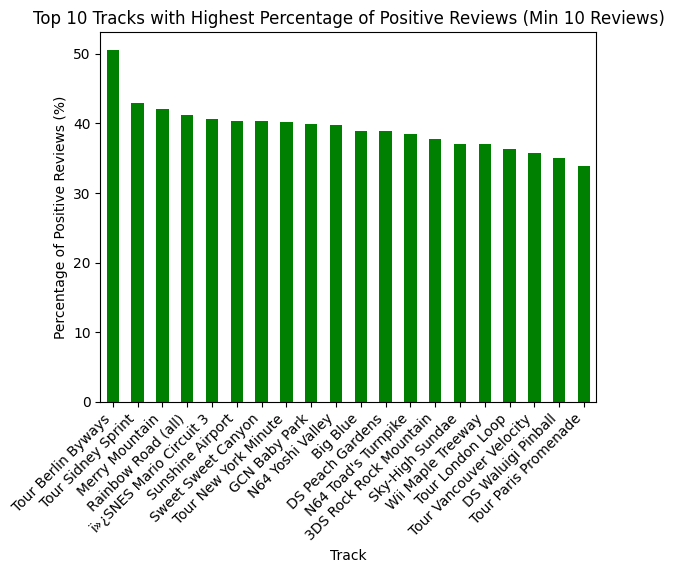

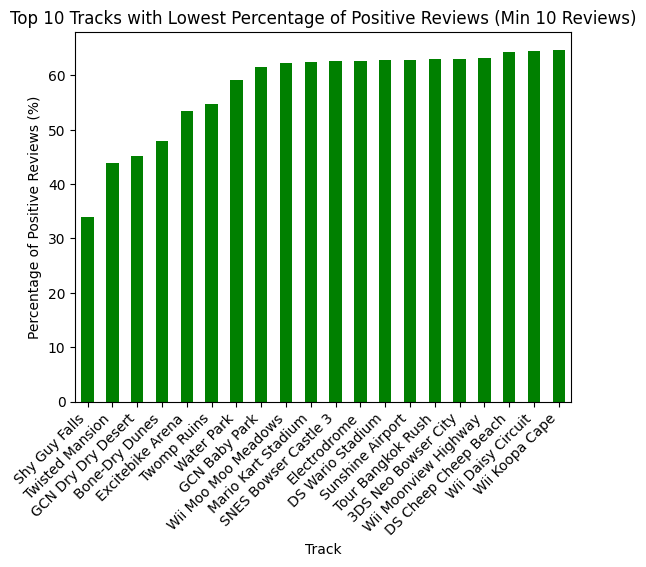

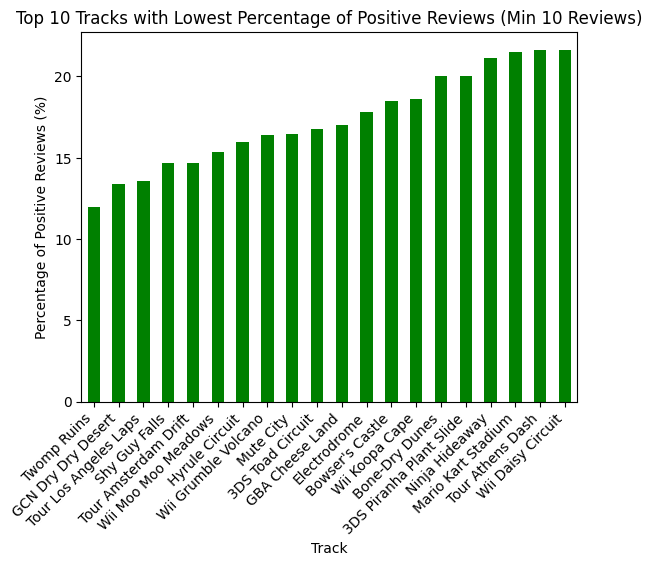

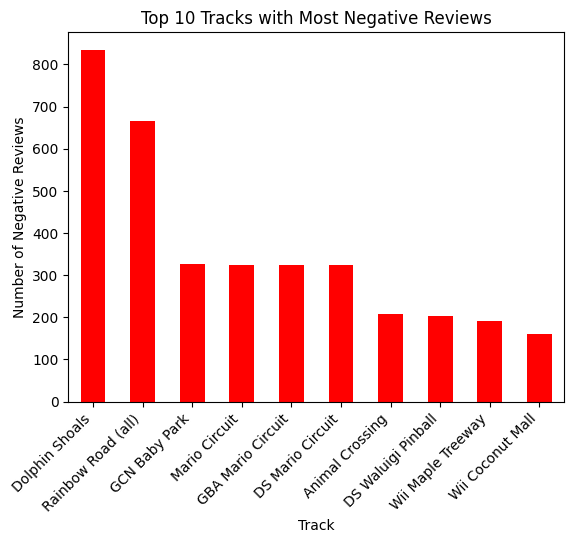

In [23]:
plot_top_positive_percentage(track_sentiment_counts, num_bars=20)
plot_top_positive_percentage(track_sentiment_counts_BERT,num_bars=20)
plot_worst_positive_percentage(track_sentiment_counts, num_bars=20)
plot_worst_positive_percentage(track_sentiment_counts_BERT, num_bars=20)
plot_top_n_negative_reviews(track_sentiment_counts)

In [24]:
from transformers import pipeline

# Initialize the HuggingFace sentiment-analysis pipeline
nlp = pipeline("sentiment-analysis")

def analyze_sentiment(texts):
    return nlp(texts)


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [25]:
def ranking(track_reviews):
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame.from_dict(track_reviews, orient='index', columns=['Positive', 'Negative'])
    
    # Calculate the total number of reviews and the percentage of positive reviews
    df['Total_Reviews'] = df['Positive'] + df['Negative']
    df['Positive_Percentage'] = (df['Positive'] / df['Total_Reviews']) * 100

    # Sort by the percentage of positive reviews and select the top 10
    df_sorted = df.sort_values(by='Positive_Percentage', ascending=True)

    return df_sorted

In [28]:
rank_df = ranking(track_sentiment_counts_BERT)